In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from typing import Union
from tqdm import tqdm_notebook
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Data Limpia.csv')
#renombramos las columnas a Fecha y Cantidad de Prescripciones
df.columns = ['Fecha', 'Cantidad de Prescripciones']

Ahora queremos desarrollar el modelo, para ello, debemos empezar por ver que nuestra data presentada no tenga tendencia, sea estacional y no tenga autocorrelacion entre sus datos, aplicamos de esta forma el método ADF comprobarlo. ADF nos ayuda a comprobar si es que exite tendencia y estacionalidad en la serie de tiempo.

In [3]:
from statsmodels.tsa.stattools import adfuller

#Función para probar la estacionaridad de la serie de tiempo
ADF = adfuller(df['Cantidad de Prescripciones'])
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])

ADF Statistic: 3.145190
p-value: 1.000000


Ambos valores nos indican que nuestra data no es estacionaria y que existe una tendencia en los datos, ADF utiliza hipotesis para comprobar ambos dos, si esque un p-value menor a 0, se puede rechazar lo que llamamos *hipotesis nula* y confirmar que se trata de una serie de tiempo estacional y sin tendencia, eso y cumplir que el ADF statistic es un valor en los negativos.

Aquí aplicamos un método de transformación para que la serie de tiempo sea estacionaria, utilizando la diferenciación

In [4]:
Diff = np.diff(df['Cantidad de Prescripciones'],1)
ADF = adfuller(Diff)
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])

ADF Statistic: -2.495174
p-value: 0.116653


Los valores cambian para mejor, tomando en consideración que esperamos que el p-value disminuyera y que ADFS tomará valor negativo, sin embargo, aun no cumple lo suficientes requisitos como para ser totalmente estacionaria, por lo que haremos el tratamiento nuevamente.

Para el siguiente tratamiento tomaremos n=12 utilizando la diferenciación ya realizada, esto lo hacemos ya que la data es obtenida de forma mensual, teniendo así 12 meses en el año.

In [5]:
Season_Diff = np.diff(df['Cantidad de Prescripciones'],12)
ADF = adfuller(Season_Diff)
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])

ADF Statistic: -18.779673
p-value: 0.000000


Ahora podemos confirmar que nuestra serie de tiempo es estacionaria luego de realizar 1 diferenciación, y 1 diferenciación estacional (d=1 y D=1).

Para el entrenamiento del modelo no podemos ocupar el clásico train_test_split, esto porque es imperativo que las series de tiempo sean trabajadas en orden, el TTS toma porcentajes aleatorios de la muestra como train y test, pero para casos de este proyecto, se debe tomar un entrenamiento con cierto porcentaje de la data desde su valor inicial hasta un valor arbitrario, de acuerdo a lo que sea pertinente al modelo.

Tenemos data de 204 meses, por lo que utilizaremos 156 meses para el entrenamiento y los ultimos 4 años para realizar las pruebas:

In [6]:
train = df['Cantidad de Prescripciones'][:156]
test = df['Cantidad de Prescripciones'][156:]

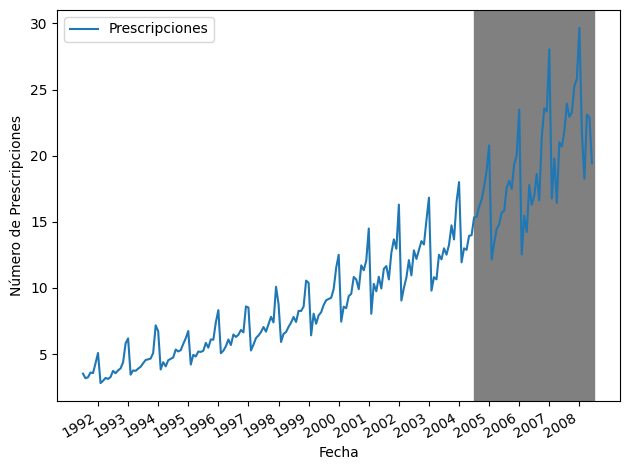

In [7]:
fig, ax = plt.subplots()

ax.plot(df['Cantidad de Prescripciones'], label='Prescripciones')
ax.set_xlabel('Fecha')
ax.set_ylabel('Número de Prescripciones')
ax.axvspan(156, 204, color='grey')
fig.autofmt_xdate()

plt.legend()
plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
plt.tight_layout()

La parte en gris en la gráfica es la porción de datos que se utilizará en el test.

Una vez definidas las muestras de entrenamiento y prueba, procedemos a desarrollar el modelo. Como se mencionó inicialmente, el modelo a utilizar es SARIMA, la razón para ocupar este por sobre ARIMA es que nuestra serie de tiempo presenta patrones estacionales, siendo SARIMA una extensión de ARIMA que toma en cuenta estos patrones. 

Hay que tomar en cuenta que SARIMA es un caso especial de SARIMAX, la mayor cualidad de este último es que toma en consideración variables exógenas, siendo esta cualquiera característica externa que afecte a la serie de tiempo, para casos de este proyecto, solo tomamos en consideración la cantidad de prescripciones realizadas en un mes, no hay factores externos que influyan.

Respecto al modelo elegido, SARIMA es un modelo que utiliza parámetros p, d, q, P, D, Q o bien SARIMA(p,d,q)(P,D,Q)m, para su modelación se seguirá la estructura de un SARIMAX (dado que es un caso especial), por lo que primero hay que empezar encontrar los valores de parámetros que optimicen el SARIMAX, conocemos ya 3 de ellos, siendo estos d, D y m, como 1, 1 y 12 respectivamente (estos valores de d y D son los que transforman nuestra serie de tiempo en estacionaria).

Con SARIMA(p,1,q)(P,1,Q)12 solo queda terminar de optimizar para encontrar valores para los parámetros faltantes que minimicen el AIC (Akaike's information criterion), este criterio nos ayuda a seleccionar el mejor modelo estadistico entre varios modelos presentados.

In [8]:
#Modelo de optimización SARIMAX
def OptSarimax(endog: Union[pd.Series,list], exog: Union[pd.Series,list], order_list: list, d: int, D: int, s:int):
    Resultados = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, exog, order=(order[0], d, order[1]), seasonal_order=(order[2], D, order[3], s), simple_differencing=False)
            model_fit = model.fit(disp=False)
        except:
            continue
        Resultados.append([order, model_fit.aic])

    Resultados_df = pd.DataFrame(Resultados)
    Resultados_df.columns = ['Orden', 'AIC']
    Resultados_df = Resultados_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return Resultados_df

In [9]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

order_list = list(product(ps, qs, Ps, Qs))

d=1   #diferenciación
D=1   #diferenciación estacional
s=12  #periodo de la estacionalidad

In [10]:
Resultados_SARIMA = OptSarimax(train, None, order_list, d, D, s)
Resultados_SARIMA

  0%|          | 0/625 [00:00<?, ?it/s]

,Orden,AIC
0,"(2, 3, 0, 1)",218.728891
1,"(2, 3, 0, 2)",218.819023
2,"(2, 3, 1, 1)",219.103185
3,"(2, 3, 2, 0)",219.562120
4,"(2, 3, 3, 0)",220.425743
...,...,...
620,"(0, 0, 4, 2)",308.080199
621,"(0, 0, 2, 0)",310.167273
622,"(0, 0, 0, 0)",310.796231
623,"(0, 0, 0, 1)",312.007025


Obtenemos 625 combinaciones diferentes para encontrar los parámetros adecuados.

De nuevo, ¿Para qué queriamos estos valores? estos son los valores de los parámetros para los cuales se minimiza el AIC, en el orden (p,q,P,Q), como observamos en el DataFrame, estos ya estan ordenados en orden ascendente con respecto a su AIC, por lo que los valores que minimizan mejor el AIC son (2, 3, 0, 1).

Ahora tenemos todos los valores para los parámetros del mejor modelo SARIMA (según la minimización del AIC), con esto por fin podemos modelar completamente el modelo.

SARIMA(p,d,q)(P,D,Q)m = SARIMA(2,1,3)(0,1,1)12

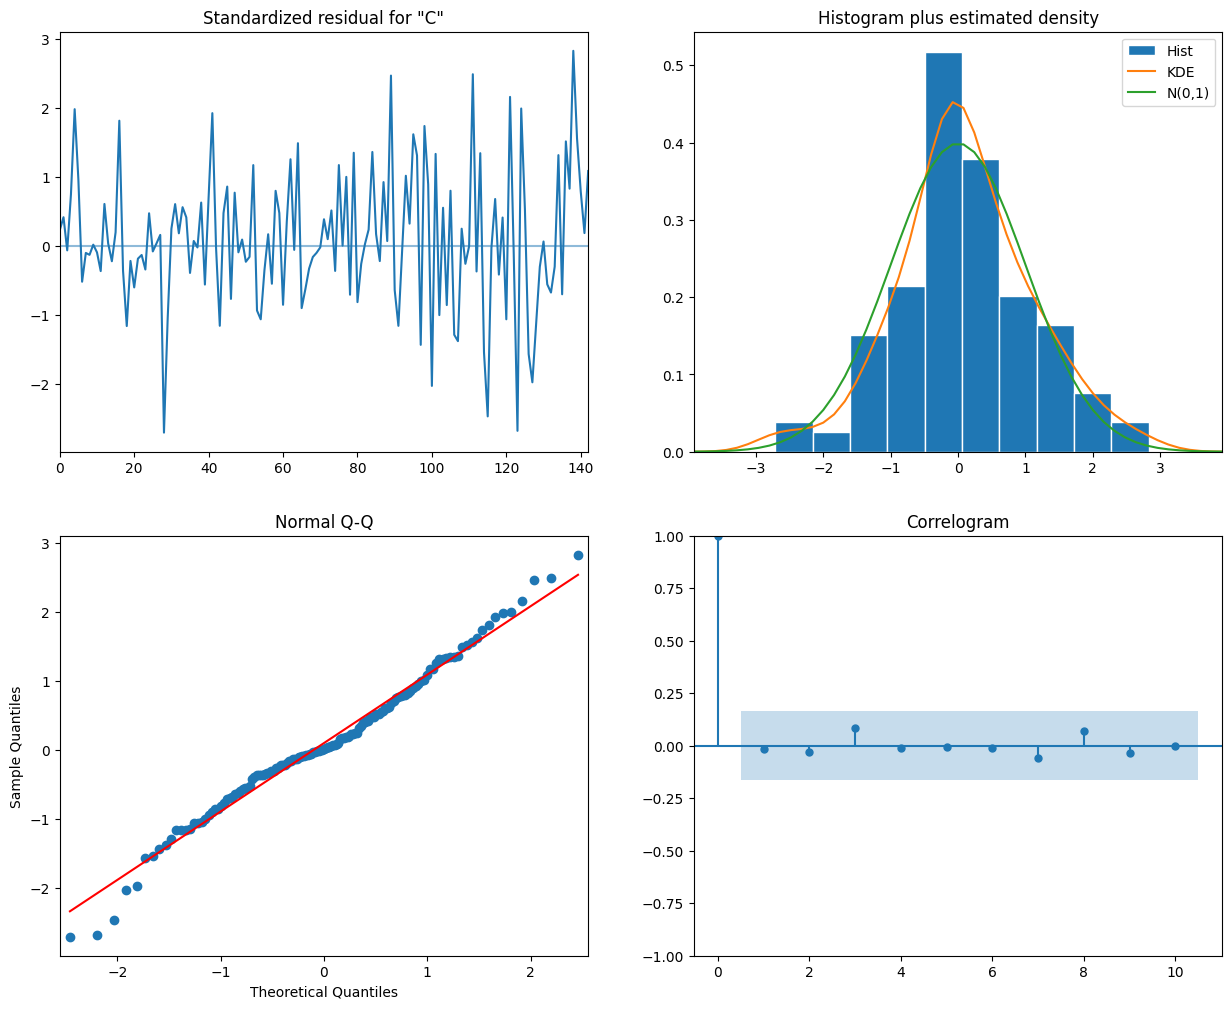

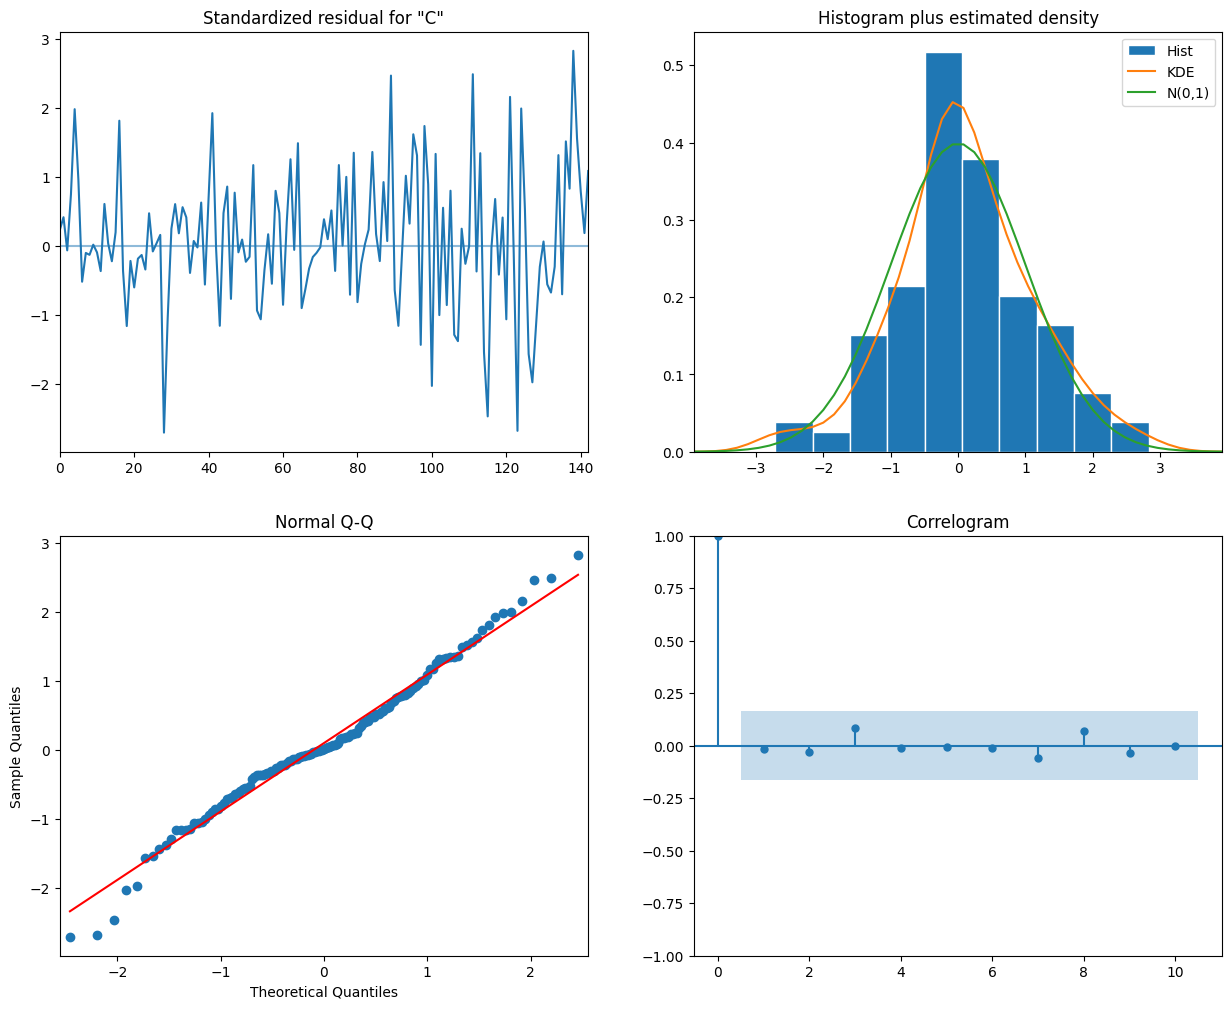

In [11]:
#Modelo SARIMA
SARIMA = SARIMAX(train, order=(2, 1, 3), seasonal_order=(0, 1, 1, 12), simple_differencing=False)
SARIMA_fit = SARIMA.fit(disp=False)
SARIMA_fit.plot_diagnostics(figsize=(15, 12))

¿Que observamos en estos gráficos?

- Superior izquierdo nos indica la tendencia, no hay, la varianza pareciera mantenerse constante, por lo podemos asumir que tenemos un modelo estacionario.
- Superior derecho muestra la distribución que tiene el residuo siendo similar a una Normal.
- Inferior izquierdo muestra la relación lineal que existe entre los valores de muestra y los teoricos dados por el modelo.
- Inferior derecho indica la correlación existente entre las variables, tampoco hay, estos pequeños valores se asimilan a lo que llamamos anteriormente como ruido blanco.

--------------------------------------------------------------------------------------------------------


Optimizamos para nuevos conjuntos de entrenamiento y prueba:

In [12]:
train2 = df['Cantidad de Prescripciones'][:168]
test2 = df['Cantidad de Prescripciones'][168:]

def OptSarimax(endog: Union[pd.Series,list], exog: Union[pd.Series,list], order_list: list, d: int, D: int, s:int):
    Resultados = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, exog, order=(order[0], d, order[1]), seasonal_order=(order[2], D, order[3], s), simple_differencing=False)
            model_fit = model.fit(disp=False)
        except:
            continue
        Resultados.append([order, model_fit.aic])

    Resultados_df = pd.DataFrame(Resultados)
    Resultados_df.columns = ['Orden', 'AIC']
    Resultados_df = Resultados_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return Resultados_df

ps = range(0, 5, 1)
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

order_list = list(product(ps, qs, Ps, Qs))

d=1
D=1
s=12

Resultados_SARIMA2 = OptSarimax(train2, None, order_list, d, D, s)
Resultados_SARIMA2

  0%|          | 0/625 [00:00<?, ?it/s]

,Orden,AIC
0,"(3, 1, 1, 3)",270.951238
1,"(2, 4, 1, 3)",271.215580
2,"(3, 3, 1, 3)",271.440643
3,"(4, 1, 1, 3)",272.145443
4,"(0, 4, 1, 3)",272.152514
...,...,...
620,"(0, 0, 3, 4)",352.226635
621,"(0, 0, 2, 4)",353.250508
622,"(0, 0, 0, 1)",354.751898
623,"(0, 0, 1, 0)",357.173909


(3,1,1,3) es que optimiza mejor nuestro modelo para 3 años como muestra de prueba.

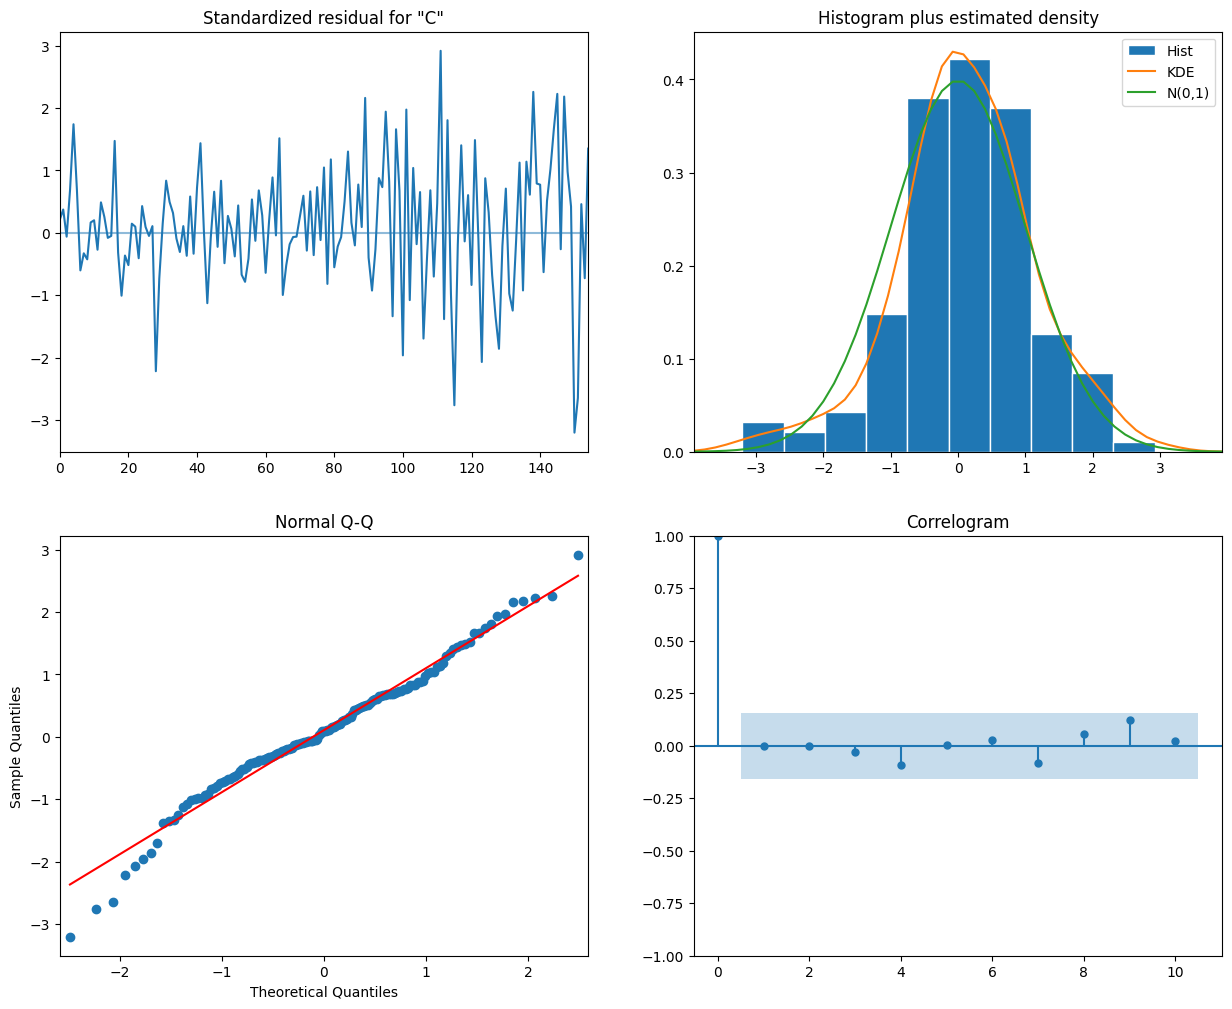

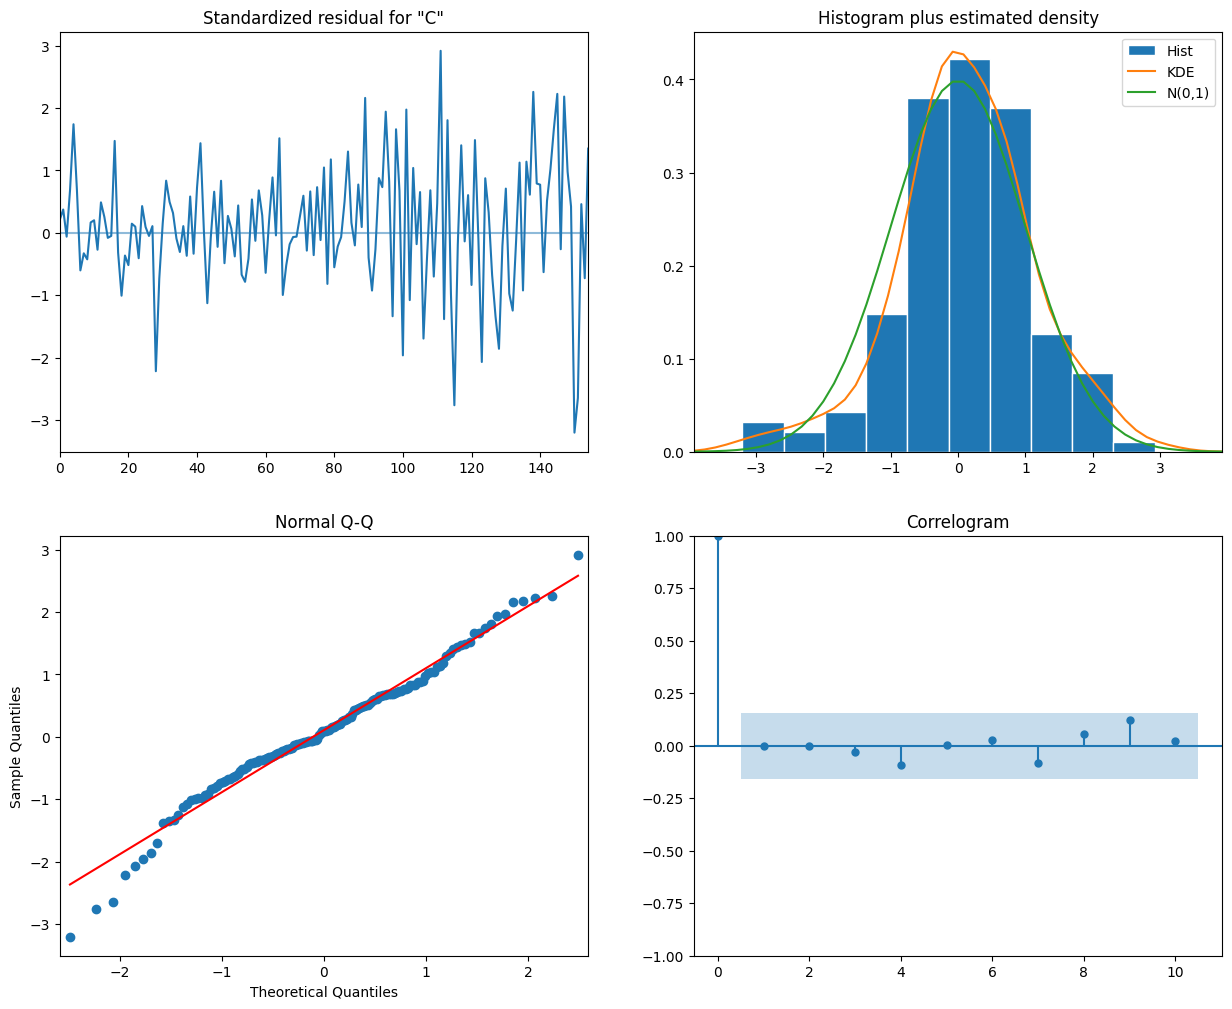

In [14]:
train2 = df['Cantidad de Prescripciones'][:168]
test2 = df['Cantidad de Prescripciones'][168:]

#Modelo SARIMA
SARIMA = SARIMAX(train2, order=(3, 1, 1), seasonal_order=(1, 1, 3, 12), simple_differencing=False)
SARIMA_fit = SARIMA.fit(disp=False)
SARIMA_fit.plot_diagnostics(figsize=(15, 12))